In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import gc
import re
import folium
import textstat
from scipy import stats
from colorama import Fore, Back, Style, init

import math
import numpy as np
import scipy as sp
import pandas as pd

import random
import networkx as nx
from pandas import Timestamp

from PIL import Image
from IPython.display import SVG
from keras.utils import model_to_dot

import requests
from IPython.display import HTML

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
import matplotlib.pyplot as plt

tqdm.pandas()

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import transformers
import tensorflow as tf

from tensorflow.keras.callbacks import Callback
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

from tensorflow.keras.models import Model
#from kaggle_datasets import KaggleDatasets
from tensorflow.keras.optimizers import Adam
from tokenizers import BertWordPieceTokenizer
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding
from tensorflow.keras.layers import LSTM, GRU, Conv1D, SpatialDropout1D

from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import activations
from tensorflow.keras import constraints
from tensorflow.keras import initializers
from tensorflow.keras import regularizers

import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.constraints import *
from tensorflow.keras.initializers import *
from tensorflow.keras.regularizers import *

from sklearn import metrics
from sklearn.utils import shuffle
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer,\
                                            CountVectorizer,\
                                            HashingVectorizer

from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer  

import nltk
from textblob import TextBlob

from nltk.corpus import wordnet
from nltk.corpus import stopwords
from googletrans import Translator
from nltk import WordNetLemmatizer
#from polyglot.detect import Detector
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer

stopword=set(STOPWORDS)

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

np.random.seed(0)

Using TensorFlow backend.


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
textID           27481 non-null object
text             27480 non-null object
selected_text    27480 non-null object
sentiment        27481 non-null object
dtypes: object(4)
memory usage: 858.9+ KB


In [4]:
print(train.shape)
print(test.shape)

(27481, 4)
(63812, 3)


In [5]:
train.dropna(inplace=True)

In [6]:
train.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative

In [7]:
train.describe()

textID                                               text  \
count        27480                                              27480   
unique       27480                                              27480   
top     05bdfb2daf   thanks so much! we love fanmail  talk to us a...   
freq             1                                                  1   

       selected_text sentiment  
count          27480     27480  
unique         22463         3  
top             good   neutral  
freq             199     11117

In [8]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

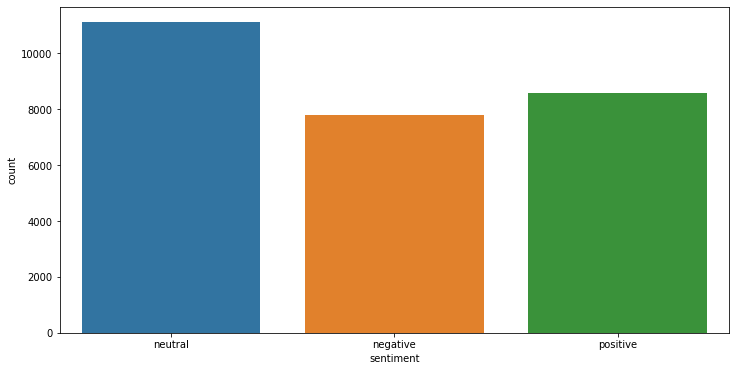

In [9]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=train)

In [10]:
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

In [11]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [12]:
results_jaccard=[]

for ind,row in train.iterrows():
    sentence1 = row.text
    sentence2 = row.selected_text

    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

In [13]:
jaccard = pd.DataFrame(results_jaccard,columns=["text","selected_text","jaccard_score"])
train = train.merge(jaccard,how='outer')

In [14]:
train['Num_words_ST'] = train['selected_text'].apply(lambda x:len(str(x).split())) #Number Of words in Selected Text
train['Num_word_text'] = train['text'].apply(lambda x:len(str(x).split())) #Number Of words in main text
train['difference_in_words'] = train['Num_word_text'] - train['Num_words_ST'] #Difference in Number of words text and Selected Text

In [15]:
hist_data = [train['Num_words_ST'],train['Num_word_text']]

group_labels = ['Selected_Text', 'Text']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels,show_curve=False)
fig.update_layout(title_text='Distribution of Number Of words')
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)
fig.show()

In [16]:
train.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  jaccard_score  Num_words_ST  \
0  I`d have responded, if I were going   neutral       1.000000             7   
1                             Sooo SAD  negative       0.200000             2   
2                          bullying me  negative       0.166667             2   
3                       leave me alone  negative       0.600000             3   
4                        Sons of ****,  negative       0.214286             3   

   Num_word_text  difference_in_words  
0              7                    0  
1             10                    8  
2              5                    3  
3              5                    2  
4             14                   11

In [17]:
import string

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [18]:
train['text'] = train['text'].apply(lambda x:clean_text(x))
train['selected_text'] = train['selected_text'].apply(lambda x:clean_text(x))

In [19]:
from collections import Counter

train['temp_list'] = train['selected_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

In [20]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [21]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
train['temp_list'] = train['temp_list'].apply(lambda x:remove_stopword(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='gist_rainbow')

In [23]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

In [24]:
train['temp_list1'] = train['text'].apply(lambda x:str(x).split()) #List of words in every row for text
train['temp_list1'] = train['temp_list1'].apply(lambda x:remove_stopword(x)) #Removing Stopwords

In [25]:
top = Counter([item for sublist in train['temp_list1'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

In [26]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [27]:
train['sentiment'].value_counts()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

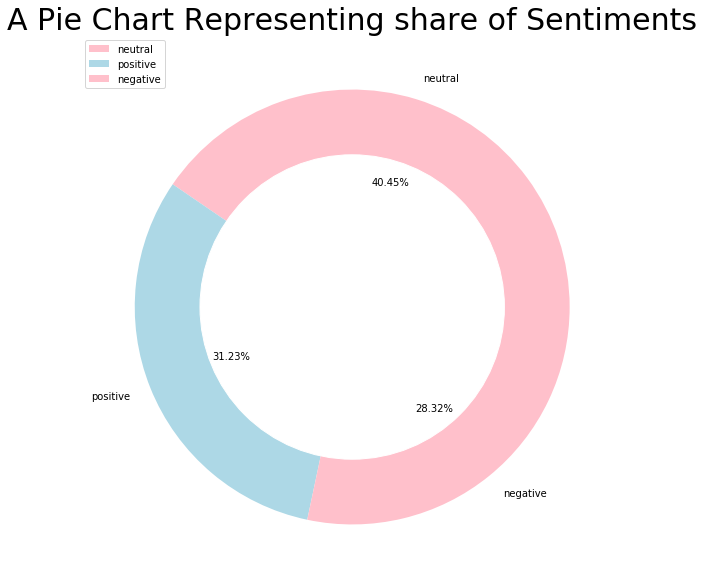

In [28]:
# making a donut chart to represent share of each.

size = [11117, 8582 , 7781]
colors = ['pink', 'lightblue']
labels = "neutral","positive","negative"

my_circle = plt.Circle((0, 0), 0.7, color = 'white')

plt.rcParams['figure.figsize'] = (10, 10)
plt.pie(size, colors = colors, labels = labels, autopct = '%.2f%%')
plt.axis('off')
plt.title('A Pie Chart Representing share of Sentiments', fontsize = 30)
p = plt.gcf()
plt.gca().add_artist(my_circle)
plt.legend()
plt.show()

# Most common words Sentiments Wise




In [29]:
Positive= train[train['sentiment']=='positive']
Negative= train[train['sentiment']=='negative']
Neutral = train[train['sentiment']=='neutral']

# POSITIVE WORDS

In [30]:
#MosT common positive words
top = Counter([item for sublist in Positive['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='prism_r')

In [31]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

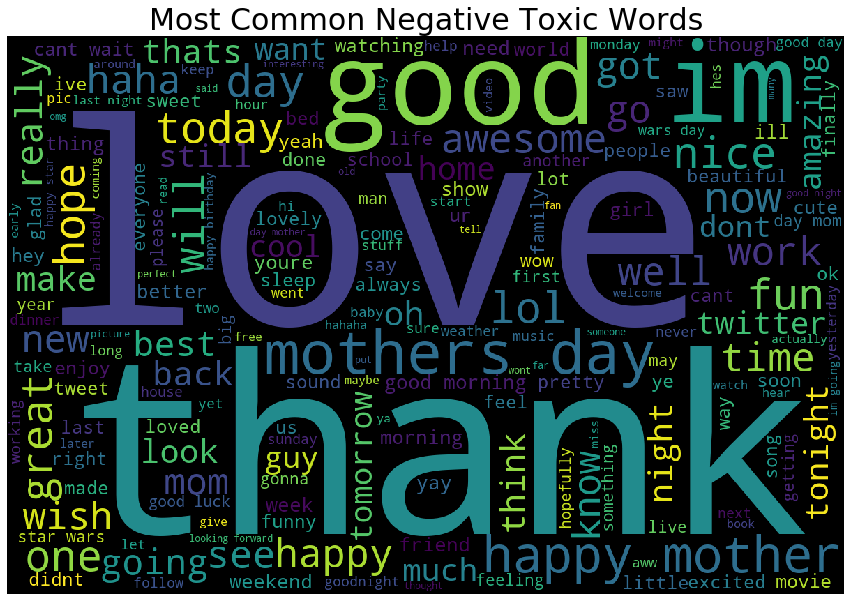

In [32]:
Positive_sentiments = " ".join([text for text in train['text'][train['sentiment'] == "positive"]])

from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'black', stopwords = stopwords, width = 1200, height = 800).generate(Positive_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Most Common Negative Toxic Words', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

# Negative Words

In [33]:
#MosT common negative words
top = Counter([item for sublist in Negative['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='gist_rainbow')

In [34]:
fig = px.treemap(temp_negative, path=['Common_words'], values='count',title='Tree Of Most Common Negative Words')
fig.show()

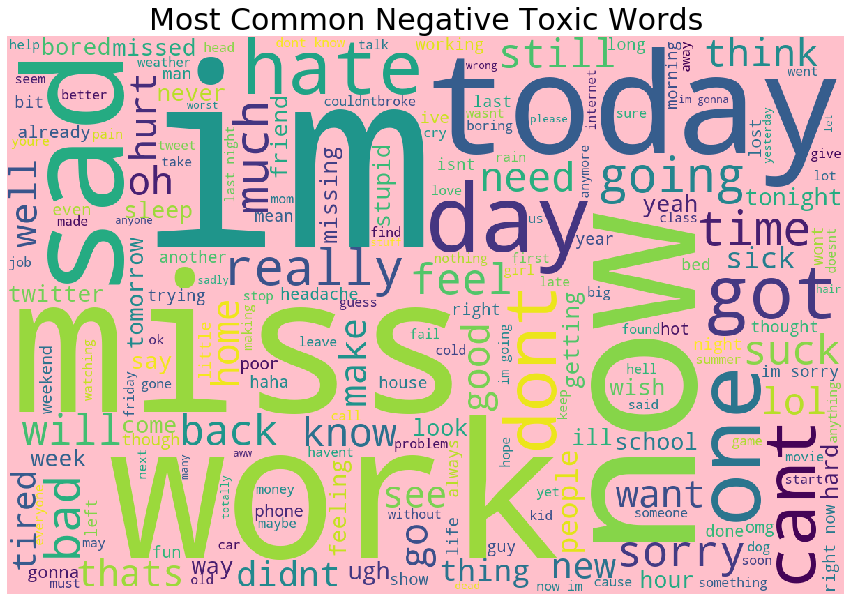

In [35]:
Negative_sentiments = " ".join([text for text in train['text'][train['sentiment'] == "negative"]])

from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'pink', stopwords = stopwords, width = 1200, height = 800).generate(Negative_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Most Common Negative Toxic Words', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

# Neutral words

In [36]:

top = Counter([item for sublist in Neutral['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='coolwarm')

In [37]:
fig = px.bar(temp_neutral, x="count", y="Common_words", title='Most Commmon Neutral Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [38]:
fig = px.treemap(temp_neutral, path=['Common_words'], values='count',title='Tree Of Most Common Neutral Words')
fig.show()

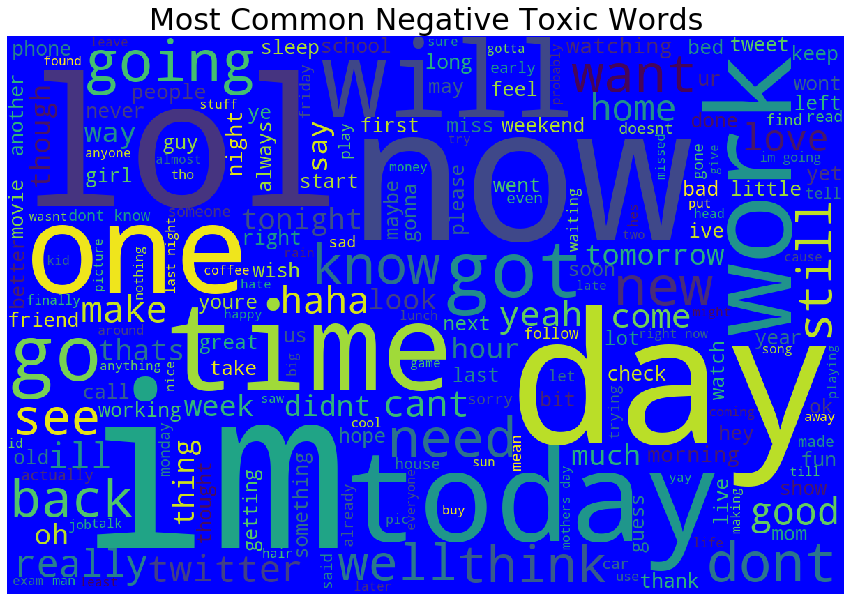

In [39]:
Neutal_sentiments = " ".join([text for text in train['text'][train['sentiment'] == "neutral"]])

from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'blue', stopwords = stopwords, width = 1200, height = 800).generate(Neutal_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Most Common Negative Toxic Words', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

# Unique Words in each Segment

In [40]:
raw_text = [word for word_list in train['temp_list1'] for word in word_list]

In [41]:
def words_unique(sentiment,numwords,raw_words):
    '''
    Input:
        segment - Segment category (ex. 'Neutral');
        numwords - how many specific words do you want to see in the final result; 
        raw_words - list  for item in train_data[train_data.segments == segments]['temp_list1']:
    Output: 
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    allother = []
    for item in train[train.sentiment != sentiment]['temp_list1']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in train[train.sentiment == sentiment]['temp_list1']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words

# Unique Positive Words

In [42]:
Unique_Positive= words_unique('positive', 20, raw_text)
print("The top 20 unique words in Positive Tweets are:")
Unique_Positive.style.background_gradient(cmap='Greens')

The top 20 unique words in Positive Tweets are:


In [43]:
fig = px.treemap(Unique_Positive, path=['words'], values='count',title='Tree Of Unique Positive Words')
fig.show()

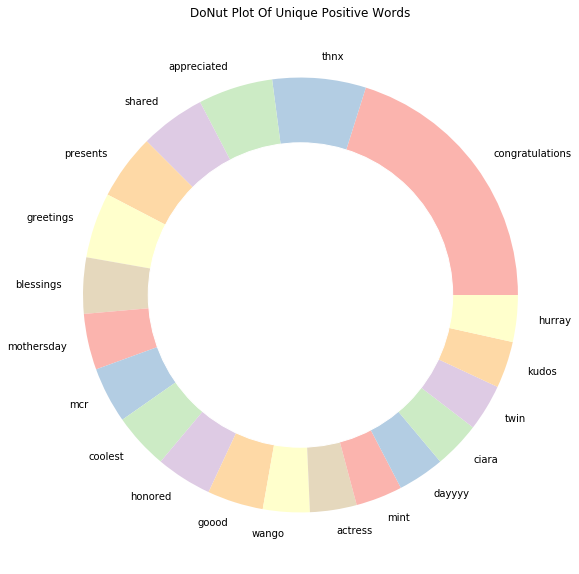

In [44]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Positive['count'], labels=Unique_Positive.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Positive Words')
plt.show()

# Unique Negative Words

In [45]:
Unique_Negative= words_unique('negative', 20, raw_text)
print("The top 10 unique words in Negative Tweets are:")
Unique_Negative.style.background_gradient(cmap='Reds')

The top 10 unique words in Negative Tweets are:


In [46]:
fig = px.treemap(Unique_Negative, path=['words'], values='count',title='Tree Of Unique Negative Words')
fig.show()

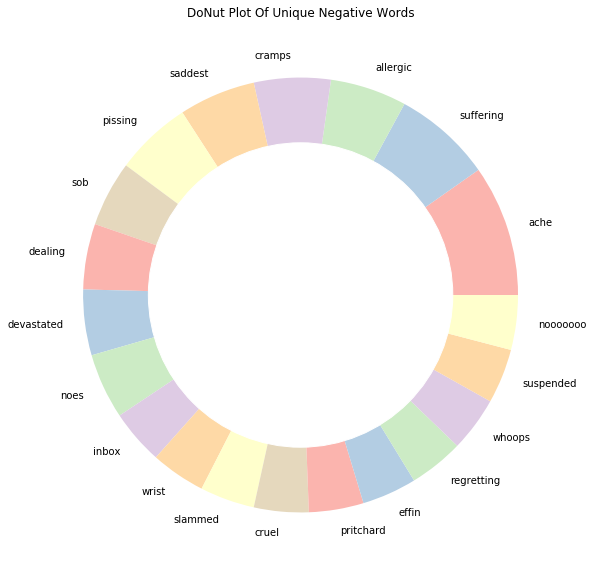

In [47]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.rcParams['text.color'] = 'black'
plt.pie(Unique_Negative['count'], labels=Unique_Negative.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Negative Words')
plt.show()

# Unique Neutral Words

In [48]:
Unique_Neutral= words_unique('neutral', 20, raw_text)
print("The top 10 unique words in Neutral Tweets are:")
Unique_Neutral.style.background_gradient(cmap='Oranges')

The top 10 unique words in Neutral Tweets are:


In [49]:
fig = px.treemap(Unique_Neutral, path=['words'], values='count',title='Tree Of Unique Negative Words')
fig.show()

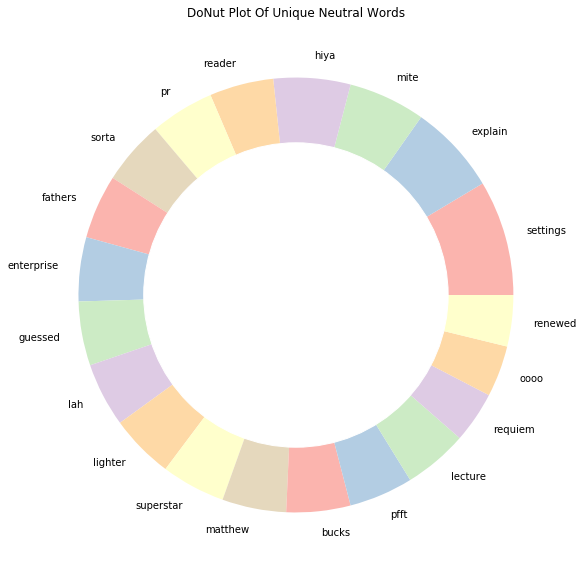

In [50]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Neutral['count'], labels=Unique_Neutral.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Neutral Words')
plt.show()

# THE END
